In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from matplotlib import gridspec

from hdf5_dataset import HDF5Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms

from tqdm import tqdm

17.236237 0
6.5010157 0
17.692844 1
6.8712516 1
17.526405 2
6.6645594 2
18.372585 3
6.888762 3
18.042969 4
6.3269672 4
18.213634 5
5.917971 5
17.46614 6
6.602883 6
18.171892 7
6.5622883 7
17.693117 8
5.974608 8
17.610138 9
7.036406 9
17.655363 10
6.5877566 10
17.617939 11
6.6345105 11
17.579628 12
6.200261 12
17.681906 13
6.181251 13
17.884792 14
6.4568853 14
17.793596 15
6.266145 15
18.438532 16
6.778395 16
18.06133 17
6.47551 17
17.482332 18
6.5621057 18
17.35466 19
6.932192 19
17.896881 20
6.6723566 20
17.935425 21
6.4123955 21
17.502205 22
6.9412556 22
18.31364 23
6.2925296 23
17.52931 24
5.9876738 24
17.768064 25
5.917694 25
17.700855 26
7.0201306 26
17.500154 27
6.6393323 27
17.31917 28
6.990486 28
17.904694 29
6.635776 29
18.052345 30
6.598382 30
18.561396 31
6.8996224 31
17.966751 32
6.5423045 32
18.153505 33
6.2725787 33
17.48805 34
6.478358 34
18.340538 35
5.879115 35


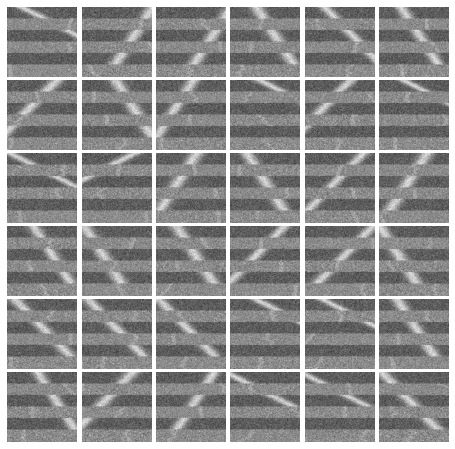

In [2]:
plt.subplots(6, 6, figsize=(8, 8))
h5_filename = '/datax/scratch/zelakiewicz/synthetic_30000_6_band.h5'
data_name = 'noisy_'
hf = h5py.File(h5_filename, 'r')
gs1 = gridspec.GridSpec(6, 6)
gs1.update(wspace=0, hspace=0.05)
for i in range(36):    
    lb = np.random.choice([1,2,3,4,5,6])
    arr = np.array(hf.get(data_name+str(i+1)+'_'+str(lb))['data'])
    print(np.amax(arr),i)
    print(np.amin(arr), i)
    waterfall = np.flip(arr.reshape(128,128),1)
    plt.subplot(gs1[i])
    plt.imshow(waterfall, cmap = 'gray', vmin=6, vmax=17)  
    plt.axis('off') 
hf.close()

In [3]:
# dataset preparation
def load_dataset(batch_size = 512, path = "/datax/scratch/zelakiewicz/", normalize=False, mean_tens=None, std_tens=None):
    if normalize == True:
        dataset = HDF5Dataset(file_path=path , recursive=False, load_data=True,\
                                transform=[transforms.ToTensor(), transforms.Normalize(mean_tens, std_tens)]) 
    else:
        dataset = HDF5Dataset(file_path=path , recursive=False, load_data=True, transform=transforms.ToTensor())

    train_dataset, test_dataset = random_split(dataset, [25000, 5000])
   
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    return train_loader, test_loader

In [4]:
train, test = load_dataset()

In [5]:
def mean_std_for_loader(loader: DataLoader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader):
        this_batch_size = data.size()[0]
        weight = this_batch_size / loader.batch_size
        channels_sum += weight*torch.mean(data, dim=[0,1])
        channels_sqrd_sum += weight*torch.mean(data ** 2, dim=[0,1])
        num_batches += weight
    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

In [6]:
mean,std = mean_std_for_loader(train)
print(mean)
print(std)

100%|██████████| 49/49 [01:39<00:00,  2.03s/it]

tensor([[10.7002],
        [10.7118],
        [10.7215],
        [10.7313],
        [10.7410],
        [10.7496],
        [10.7575],
        [10.7630],
        [10.7707],
        [10.7764],
        [10.7807],
        [10.7858],
        [10.7891],
        [10.7930],
        [10.7956],
        [10.7977],
        [10.8003],
        [10.8037],
        [10.8043],
        [10.8076],
        [10.8076],
        [12.0262],
        [12.0268],
        [12.0277],
        [12.0272],
        [12.0267],
        [12.0264],
        [12.0272],
        [12.0270],
        [12.0270],
        [12.0269],
        [12.0266],
        [12.0266],
        [12.0275],
        [12.0276],
        [12.0266],
        [12.0271],
        [12.0286],
        [12.0265],
        [12.0280],
        [12.0267],
        [12.0264],
        [10.7393],
        [10.7327],
        [10.7254],
        [10.7189],
        [10.7113],
        [10.7055],
        [10.6986],
        [10.6917],
        [10.6843],
        [10.6785],
        [10.

In [7]:
train_norm, test_norm = load_dataset(normalize=True, mean_tens=mean, std_tens=std)

In [9]:
print(train_norm)

In [10]:
image_list = []
for i, (images, labels) in enumerate(train):
    image_list.append(images[0])
    if i==0:
        break
for images,_ in enumerate(train_norm):
    image_list.append(images[0])
    if i ==0:
        break

fig, (ax1, ax2) = plt.subplots(1,2,figsize =(10, 7))
ax1.hist(image_list[0])
ax2.hist(image_list[1])
plt.show()

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/zelakiewicz/.local/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/zelakiewicz/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/zelakiewicz/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/zelakiewicz/.local/lib/python3.7/site-packages/torch/utils/data/dataset.py", line 471, in __getitem__
    return self.dataset[self.indices[idx]]
  File "/mnt_home/zelakiewicz/code/SETI-ML/hdf5_dataset.py", line 70, in __getitem__
    x = self.transform(x)
TypeError: 'list' object is not callable


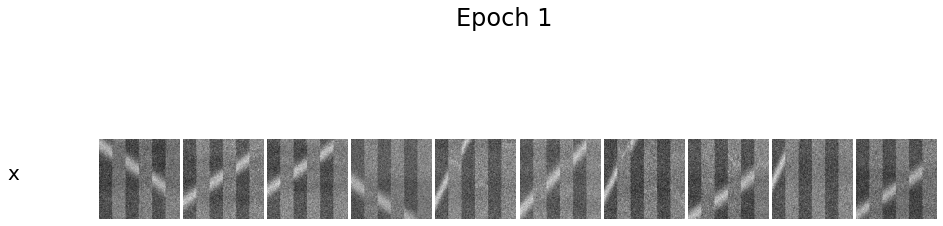

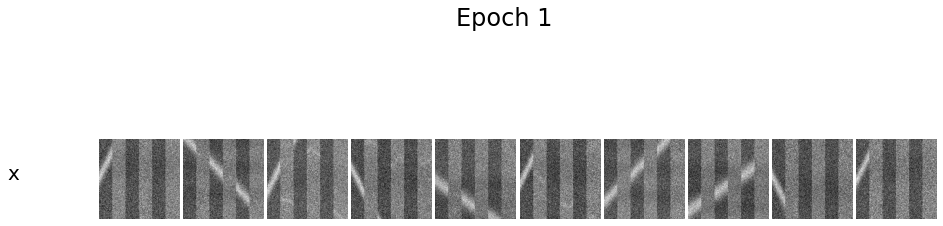

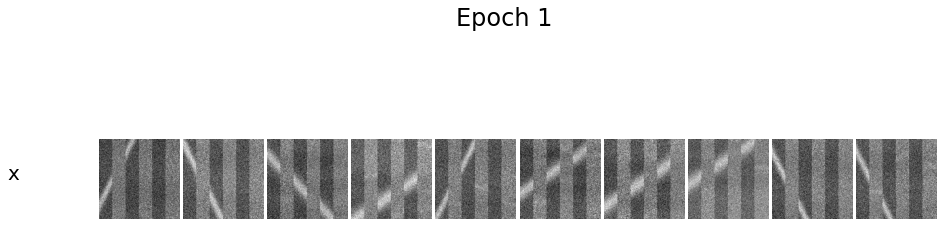

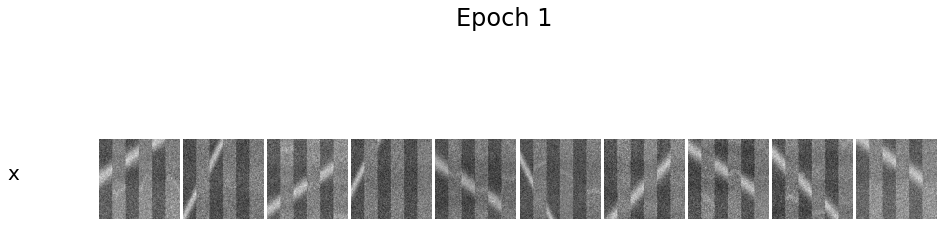

KeyboardInterrupt: 

In [18]:
for epoch in range(400):
    
    for i, (images, labels) in enumerate(train):
        images = F.normalize(images, p=2,dim=2)
        images = images.reshape(images.size(0),-1)
        n_show = 10
        real = images[:n_show]
        if i%5==0:
            c = torch.zeros(n_show, 6, dtype=torch.float32)
            c[torch.arange(n_show), labels[:n_show]] = 1
            z = torch.rand(n_show, 50)
            z = z

            real = real.reshape(n_show, 128, 128).numpy()

            fig, ax = plt.subplots(1, n_show, figsize=(15,5))
            fig.subplots_adjust(wspace=0.05, hspace=0)
            fig.suptitle('Epoch {}'.format(epoch+1))
            fig.text(0.04, 0.5, 'x', ha='left')

            for k in range(n_show):
                ax[k].imshow(real[k], cmap='gray')
                ax[k].axis('off')

            plt.show()

        # print(torch.min(images[0]), torch.max(images[0]))
        

In [20]:
abs(17329714-17475506)/17329714

0.008412833587444086